In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import itertools
import pickle

import pandas as pd
from scipy.io import savemat, loadmat
import seaborn as sns
from sklearn.metrics import (log_loss, mean_squared_error, roc_curve, auc,
                             precision_recall_fscore_support, confusion_matrix)
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange, tqdm_notebook as tqdmn

from BEKML import BEMKL, plot_distplot
from utils import poly_kernel, gauss_kernel, scoring, plot_kernel_importances, plot_e_a_mu, plot_compare_metrics

sns.set(style='ticks', context='talk')
np.set_printoptions(precision=4, linewidth=100)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/pml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('data/breast.csv', names=list(range(11)), index_col=0, na_values='?')
display(data.describe())
data = data.dropna()
display(data.head())
data.describe()

,1,2,3,4,5,6,7,8,9,10
count,699.000000,699.000000,699.000000,699.000000,699.000000,683.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.544656,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.643857,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
1000025,5,1,1,1,2,1.0,3,1,1,2
1002945,5,4,4,5,7,10.0,3,2,1,2
1015425,3,1,1,1,2,2.0,3,1,1,2
1016277,6,8,8,1,3,4.0,3,7,1,2
1017023,4,1,1,3,2,1.0,3,1,1,2


,1,2,3,4,5,6,7,8,9,10
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [3]:
X = data.iloc[:, :-1].values.copy()
y = data.iloc[:, -1].values.copy()
N, D = X.shape
y[y == 2] = -1
y[y == 4] = 1
display(X.shape, y.shape, y.mean())

(683, 9)

(683,)

-0.3001464128843338

In [4]:
rbf_init, rbf_end = -3, 7
ply_init, ply_end = 1, 4

kernel_attrs = [('rbf', 'all', i) for i in range(rbf_init, rbf_end)]
kernels = [lambda A, B: gauss_kernel(A, B, 2**i)
           for i in range(rbf_init, rbf_end)]

kernel_attrs += [('poly', 'all', i) for i in range(ply_init, ply_end)]
kernels += [lambda A, B: poly_kernel(A, B, 1, i)
            for i in range(ply_init, ply_end)]

kernel_attrs += [('rbf', j, i) for i in range(rbf_init, rbf_end)
                 for j in range(D)]
kernels += [lambda A, B: gauss_kernel(A[:, j:j+1], B[:, j:j+1], 2**i)
            for i in range(rbf_init, rbf_end) for j in range(D)]

kernel_attrs += [('poly', j, i) for i in range(ply_init, ply_end)
                 for j in range(D)]
kernels += [lambda A, B: poly_kernel(A[:, j:j+1], B[:, j:j+1], 1, i)
            for i in range(ply_init, ply_end) for j in range(D)]
len(kernels), len(kernel_attrs)

(130, 130)

In [5]:
X_train, X_test, y_train, y_test =\
        train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
max_iter = 200
model = BEMKL(kernels=kernels, alpha_lambda=1, beta_lambda=1, alpha_gamma=1,
              beta_gamma=1, alpha_omega=1, beta_omega=1, e_null_thrsh=1e-3,
              filter_kernels=True, filter_sv=True, verbose=10,
              max_iter=max_iter, optimize_hyperparams=False)
normalizer = Normalizer()
pipeline = make_pipeline(normalizer, model)
pipeline.fit(X_train, y_train)
model = pipeline.named_steps['bemkl']

Iter: 10. Bound: -1428.2397
Iter: 20. Bound: -1340.5359
Iter: 30. Bound: -1317.0610
Iter: 40. Bound: -1302.2132
Iter: 50. Bound: -1285.7312
Iter: 60. Bound: -1259.3019
Iter: 70. Bound: -1234.3259
Iter: 80. Bound: -1211.4692
Iter: 90. Bound: -1200.7573
Iter: 100. Bound: -1194.3808
Iter: 110. Bound: -1190.0778
Iter: 120. Bound: -1184.2999
Iter: 130. Bound: -1173.7308
Iter: 140. Bound: -1169.3540
Iter: 150. Bound: -1165.7873
Iter: 160. Bound: -1159.1460
Iter: 170. Bound: -1153.6781
Iter: 180. Bound: -1149.7796
Iter: 190. Bound: -1146.1314
Iter: 200. Bound: -1144.6323
Iterations total time: 13.4042


In [7]:
model_kernels = model.kernels
model_kernels_orig = model.kernels_orig

with open('breast_model.pickle', 'wb') as fp:
    model.set_params(kernels=None)
    model.kernels_orig = None
    pickle.dump(pipeline, fp)

model.set_params(kernels=model_kernels)
model.kernels_orig = model_kernels_orig

In [8]:
with open('breast_model.pickle', 'rb') as fp:
    pipeline = pickle.load(fp)

model = pipeline.named_steps['bemkl']    
model.set_params(kernels=kernels)
model.kernels_orig = kernels

In [9]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)
y_pred_proba.shape, y_pred.shape

((205, 2), (205,))

In [10]:
Km_train = model.Km_train
Km_test = model.Km_test

In [11]:
savemat('Km.mat', {
    'Km_train': Km_train.transpose(1, 2, 0),
    'y_train': y_train,
    'Km_test': Km_test.transpose(2, 1, 0),
    'y_test': y_test,
    'init_vars': model.init_vars
})

In [12]:
predictions_mat = loadmat('prediction.mat')['prediction'][0, 0]
(predictions_mat['G']['mu'][0, 0].shape, predictions_mat['G']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['f']['mu'][0, 0].shape, predictions_mat['f']['sigma'][0, 0].shape,
 predictions_mat['p'].shape)

((130, 205), (130, 205), (205, 1), (205, 1), (205, 1), (205, 1), (205, 1))

In [13]:
display(log_loss(y_test, predictions_mat['p']),
        log_loss(y_test, y_pred_proba))
display(mean_squared_error(y_pred_proba[:, 1].flatten(), predictions_mat['p'].flatten()))

0.47681684067043306

0.47681650282729826

2.2973595475355793e-12

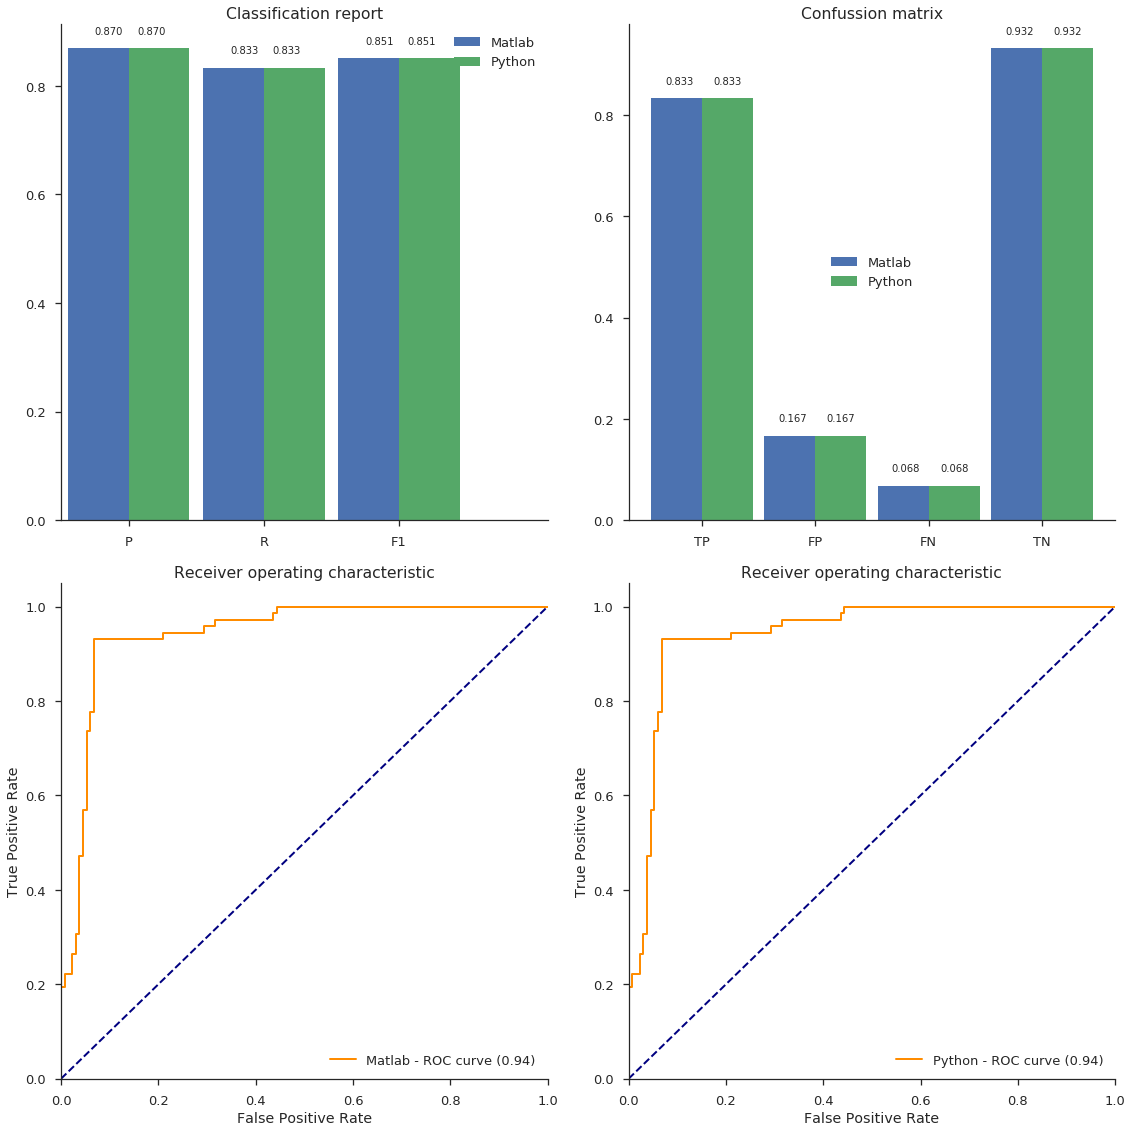

In [14]:
y_pred_proba_mat = predictions_mat['p']
y_pred_mat = np.ones_like(y_pred_proba_mat)
y_pred_mat[y_pred_proba_mat < 0.5] = -1

plot_compare_metrics(y_test, y_pred_mat, y_pred, y_pred_proba_mat, y_pred_proba[:, 1], 'Matlab', 'Python')

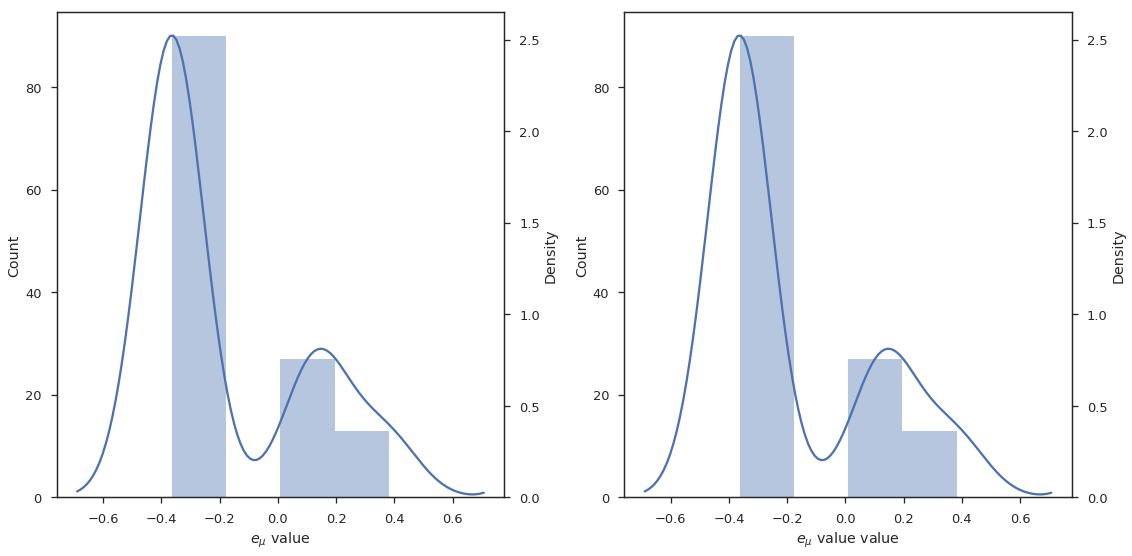

In [15]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
model.plot_e(ax=ax1)
plot_distplot(predictions_mat['be']['mu'][0, 0][1:, 0], r'$e_\mu$ value', ax=ax2)
plt.tight_layout()

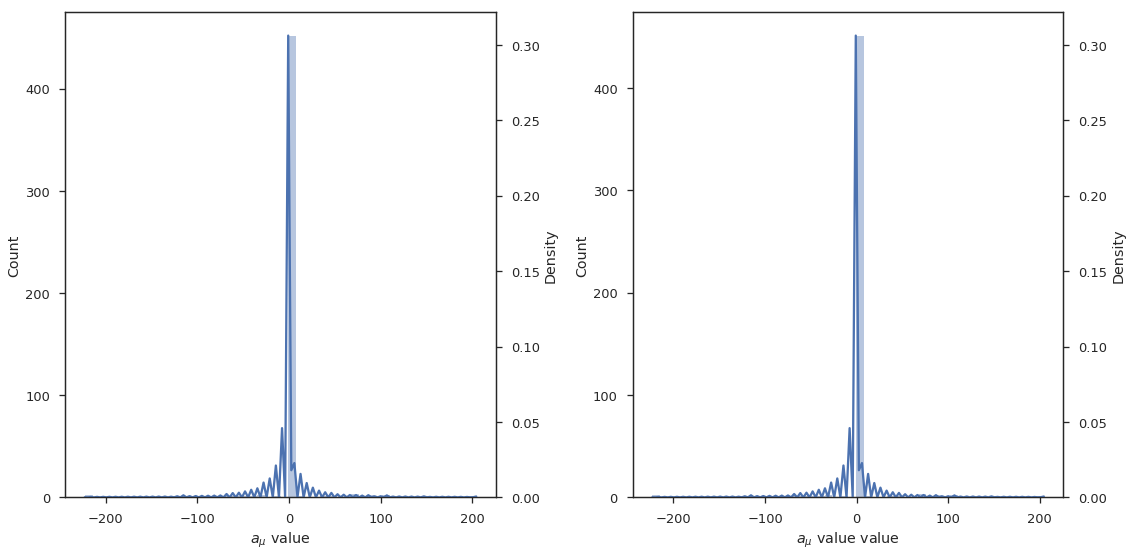

In [16]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
model.plot_a(ax=ax1)
plot_distplot(predictions_mat['a']['mu'][0, 0][1:, 0], r'$a_\mu$ value', ax=ax2)
plt.tight_layout()

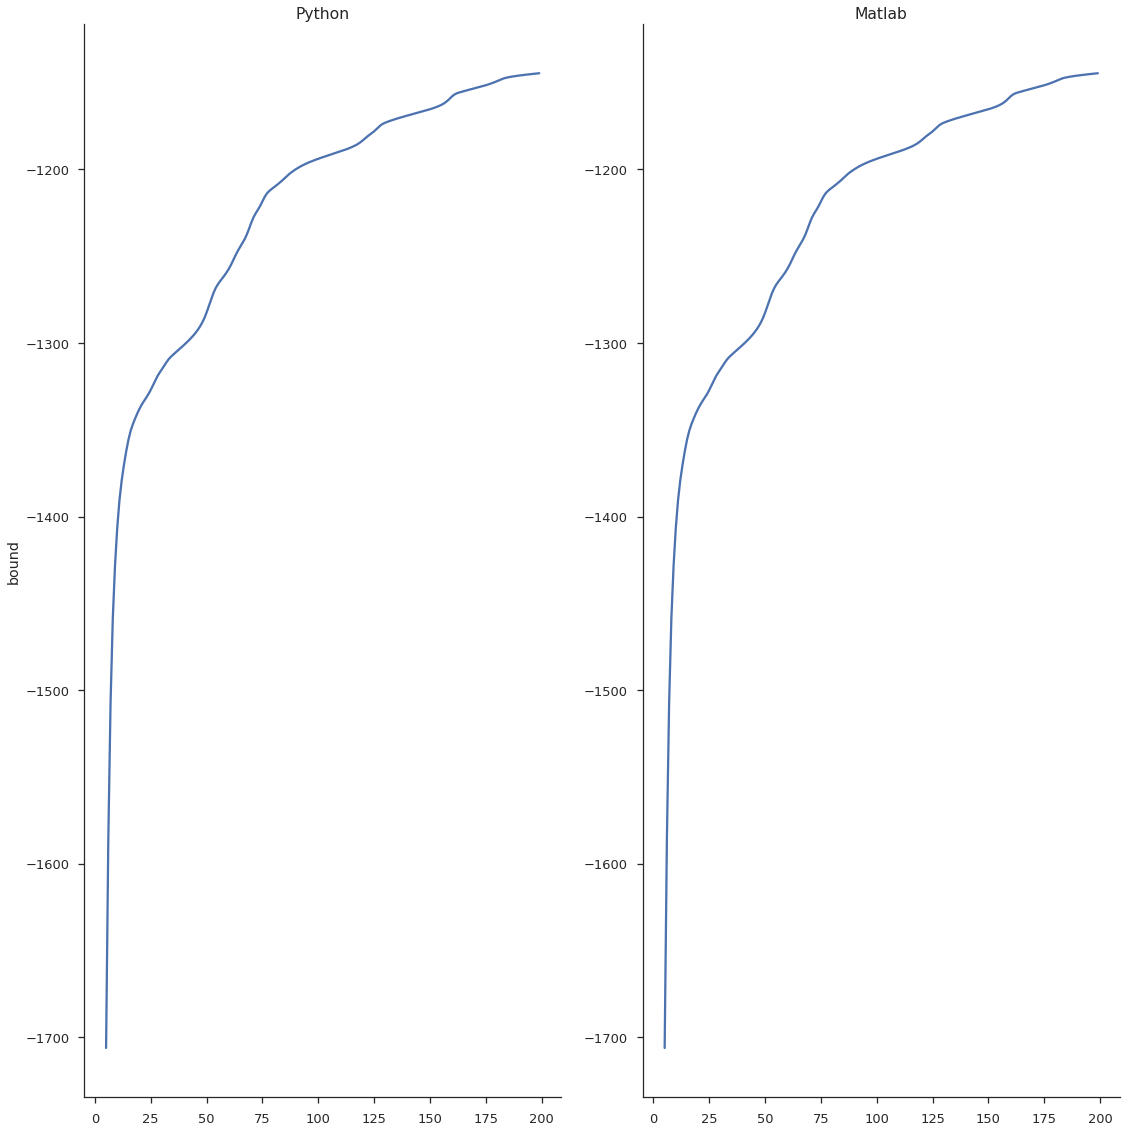

In [17]:
_, axes = plt.subplots(1, 2, figsize=(16, 16))
ax1, ax2 = axes.flatten()

from_iter = 5
x = np.arange(from_iter, len(model.bounds))
ax1.plot(x, [b[0] for b in model.bounds[from_iter:]])
ax2.plot(x, predictions_mat['bounds'][from_iter:, 0])

ax1.set_title('Python')
ax2.set_title('Matlab')
ax1.set_ylabel('bound')

sns.despine()
plt.tight_layout()